In [1]:
import numpy as np
import pandas as pd

import re
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/df_full.csv")


delete outliers to check the effect

In [3]:
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
df = df[(df['Price'] >= lower_bound) & (df['Price'] <= upper_bound)]

Lets try out Light GBM Boosting

In [4]:
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [5]:
# Convert "Renovation State" from string to binary integer
df['Renovation State'] = df['Renovation State'].apply(lambda x: 1 if x == "З ремонтом" else 0)

# Calculate 'Building_Age'
df['Building_Age'] = 2024 - df['Construction Year']

# Calculate distance to the city center
center_lat = 50.4501
center_lon = 30.5234

def calculate_airline_distance(lat, lon, center_lat=center_lat, center_lon=center_lon):
    return np.sqrt((lat - center_lat) ** 2 + (lon - center_lon) ** 2)

df['distance_to_center'] = calculate_airline_distance(df['Latitude'], df['Longitude'])

# Calculate mean distance by District ID
mean_distance_by_district = df.groupby('District ID')['distance_to_center'].mean().reset_index()
mean_distance_by_district.rename(columns={'distance_to_center': 'mean_distance_to_center'}, inplace=True)

# Merge back into the original dataframe
df = df.merge(mean_distance_by_district, on='District ID', how='left')



categorical_features = ['District ID', 'Construction Type'] + ['balcony', 'wardrobe', 'view', 'furnished', 'appliances', 'floor_heating', 'air_conditioning', 'parking', 'security_features']
numerical_features = ['Rooms', 'Area_total', 'Kitchen_area', 'Storeys', 'Floor', 'Renovation State', 'Building_Age', 'distance_to_center', 'renovation_quality', 'distance_to_nearest_metro_stations_m', 'sports_centers_count', 'supermarkets_count', 'schools_count', 'kindergartens_count', 'cafes_restaurants_count', 'public_transport_count', 'distance_to_nearest_woods_parks_m', 'distance_to_nearest_water_reservoirs_m']

# Define target variable as Log_Price (log-transformed Price)
y = np.log(df['Price'])  # Log transform the Price
X = df[categorical_features + numerical_features]

# Encode categorical features as integers (LightGBM requires this)
for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Define the LightGBM dataset
lgb_train = lgb.Dataset(X, label=y, categorical_feature=categorical_features, free_raw_data=False)

# Define the model parameters
parameters = {
    "objective": "regression",
    "metric": "mae",
    "learning_rate": 0.01,
    "num_threads": 10,
    "seed": 42,

    # Regularization parameters
    "colsample_bytree": 0.8,
    "subsample": 0.8,
    "subsample_freq": 1,
    "num_leaves": 50,
    "min_data_in_leaf": 20,

    # Handling categorical features
    "cat_smooth": 10,
    "min_data_per_group": 50
}

# Number of boosting rounds
n_rounds = 10000

# Setup KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def custom_mae_eval(preds, train_data):
    """Custom evaluation function for MAE in original price scale."""
    labels = train_data.get_label()
    preds_transformed = np.exp(preds)
    labels_transformed = np.exp(labels)
    mae_value = mean_absolute_error(labels_transformed, preds_transformed)
    return ('mae_original_scale', mae_value, False)

# Perform cross-validation and train the model with custom evaluation function
results = lgb.cv(parameters, lgb_train, n_rounds,
                 folds=kf, stratified=False,
                 feval=custom_mae_eval,
                 eval_train_metric=True,
                 callbacks=[lgb.early_stopping(50), lgb.log_evaluation(period=10)])

# Check available keys in results
print(results.keys())

<ipython-input-5-6af8ea3c30bf>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])
<ipython-input-5-6af8ea3c30bf>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])
<ipython-input-5-6af8ea3c30bf>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2097
[LightGBM] [Info] Number of data points in the train set: 9739, number of used features: 28
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2097
[LightGBM] [Info] Number of data points in the train set: 9739, number of used features: 28
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wi

In [ ]:
# Determine the number of boosting rounds based on cross-validation
num_boost_round = len(results['valid mae_original_scale-mean'])

# Train the model using the full dataset
model = lgb.train(parameters, lgb_train, num_boost_round=num_boost_round)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2097
[LightGBM] [Info] Number of data points in the train set: 12174, number of used features: 28
[LightGBM] [Info] Start training from score 15.105239


Lets have a look at lgbm-"in-built" feature importance

                                   Feature  Importance (Gain)
12                              Area_total       77836.580894
0                              District ID       33931.576474
13                            Kitchen_area       16966.435299
19                      renovation_quality        6912.802551
18                      distance_to_center        6601.027206
17                            Building_Age        4453.438482
11                                   Rooms        3860.502563
14                                 Storeys        2903.995240
6                               appliances        1712.240877
20    distance_to_nearest_metro_stations_m        1194.227794
1                        Construction Type        1155.221993
15                                   Floor        1045.667736
27       distance_to_nearest_woods_parks_m         978.068287
25                 cafes_restaurants_count         704.924142
5                                furnished         684.098443
28  dist

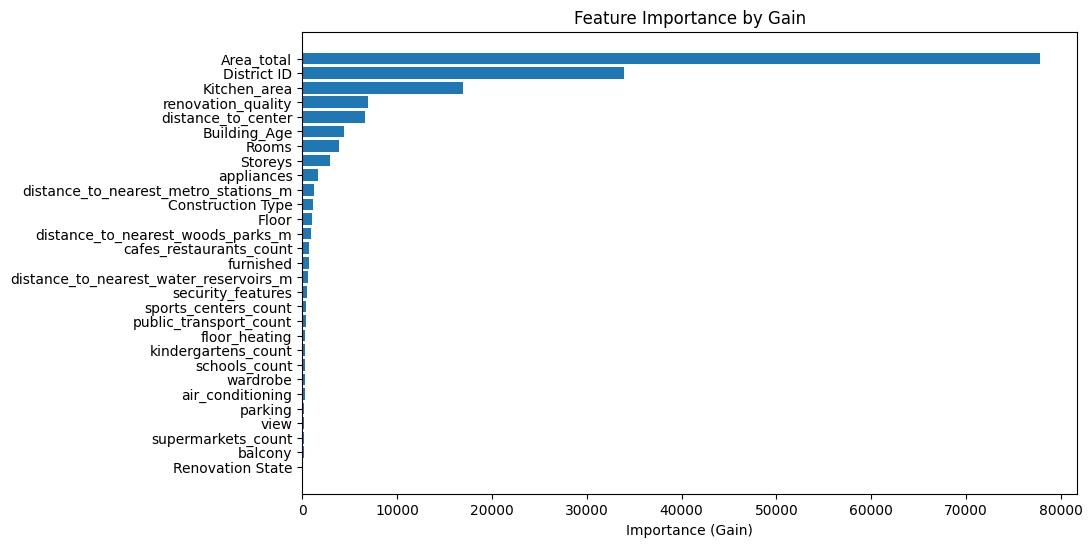

In [ ]:
import matplotlib.pyplot as plt

# Get feature importance
importance_split = model.feature_importance(importance_type='split')
importance_gain = model.feature_importance(importance_type='gain')

feature_names = X.columns

# Create a dataframe for the feature importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    #'Importance (Split)': importance_split,
    'Importance (Gain)': importance_gain
}).sort_values(by='Importance (Gain)', ascending=False)

# Display the feature importance
print(importance_df)

# Plot the feature importance (Gain)
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance (Gain)'])
plt.xlabel('Importance (Gain)')
plt.title('Feature Importance by Gain')
plt.gca().invert_yaxis()
plt.show()


In [ ]:

import shap

# Create SHAP explainer with TreeExplainer and feature_perturbation='tree_path_dependent'
explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")
shap_values = explainer.shap_values(X)

In [ ]:
# Visualize SHAP values for a specific instance
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[20,:], X.iloc[20,:])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:50], X.iloc[:50,:])

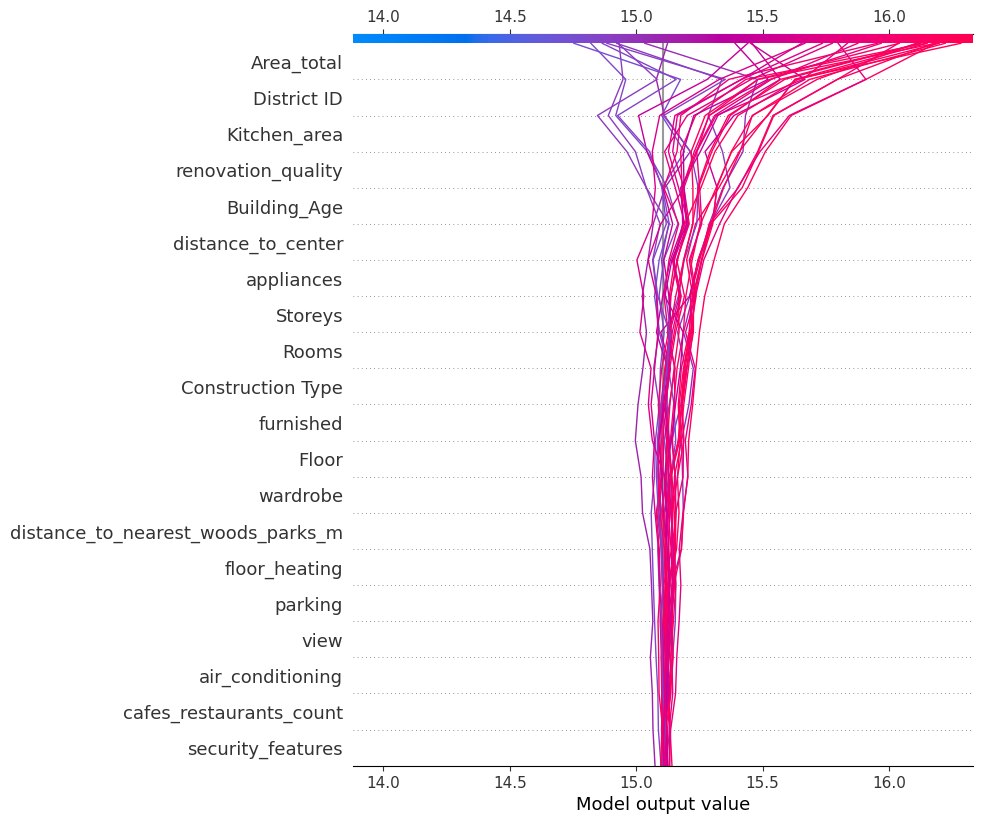

In [ ]:
shap.decision_plot(explainer.expected_value, shap_values[1000:1035, :], feature_names=list(X.columns))

<ipython-input-16-f1d436a578a0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[categorical_features] = ordinal_encoder.fit_transform(X[categorical_features])


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2097
[LightGBM] [Info] Number of data points in the train set: 12174, number of used features: 28
[LightGBM] [Info] Start training from score 15.105239


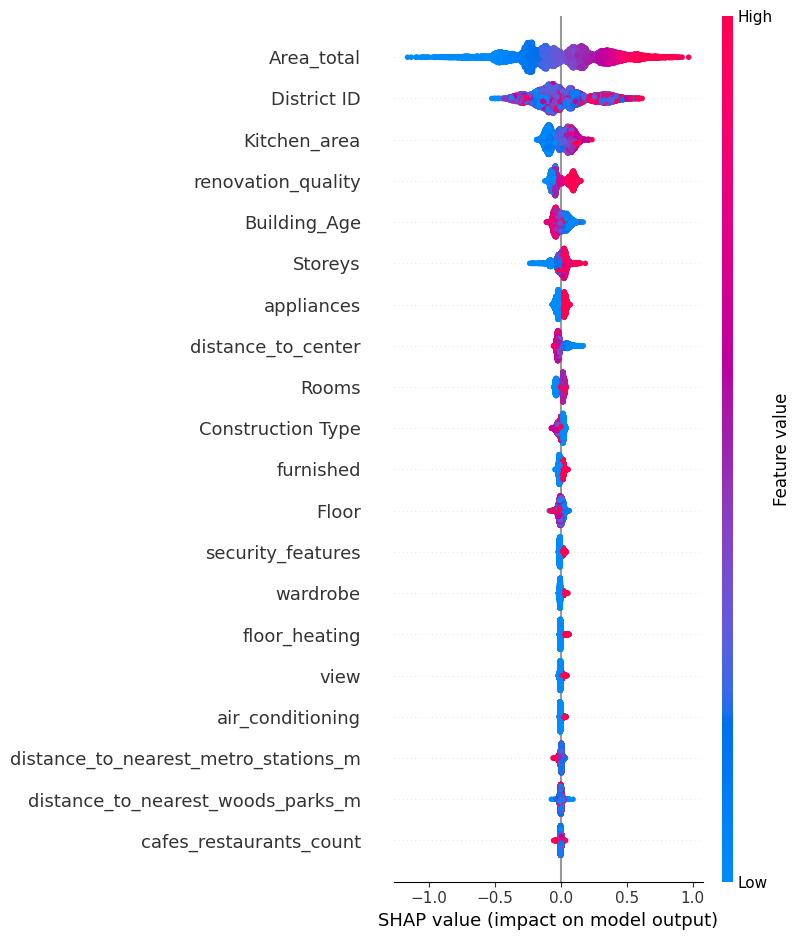

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

# Convert categorical features to their ordinal encoding
ordinal_encoder = OrdinalEncoder()
X[categorical_features] = ordinal_encoder.fit_transform(X[categorical_features])

# Now create the LightGBM dataset with these ordinal-encoded features
lgb_train = lgb.Dataset(X, label=y, categorical_feature=categorical_features)

# Train the LightGBM model again
lgb_model = lgb.train(parameters, lgb_train, num_boost_round=2499)

# Create SHAP explainer with TreeExplainer and feature_perturbation='tree_path_dependent'
explainer = shap.TreeExplainer(lgb_model, feature_perturbation="tree_path_dependent")
shap_values = explainer.shap_values(X)

# Generate summary plot with the corrected encoding
shap.summary_plot(shap_values, X)

value's impact implementation makes sense. Lets try to exclude less important features from the model.

We can see that deleting features even improved performance.

In [ ]:
categorical_features = ['District ID', 'Construction Type'] + [  'furnished', 'appliances', 'security_features']
numerical_features = ['Rooms', 'Area_total', 'Kitchen_area', 'Storeys', 'Floor', 'Building_Age', 'distance_to_center', 'renovation_quality', 'distance_to_nearest_metro_stations_m']

# Define target variable as Log_Price (log-transformed Price)
y = np.log(df['Price'])  # Log transform the Price
X = df[categorical_features + numerical_features]

# Encode categorical features as integers (LightGBM requires this)
for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Define the LightGBM dataset
lgb_train = lgb.Dataset(X, label=y, categorical_feature=categorical_features, free_raw_data=False)

# Define the model parameters
parameters = {
    "objective": "regression",
    "metric": "mae",
    "learning_rate": 0.01,
    "num_threads": 10,
    "seed": 42,

    # Regularization parameters
    "colsample_bytree": 0.8,
    "subsample": 0.8,
    "subsample_freq": 1,
    "num_leaves": 50,
    "min_data_in_leaf": 20,

    # Handling categorical features
    "cat_smooth": 10,
    "min_data_per_group": 50
}

# Number of boosting rounds
n_rounds = 10000

# Setup KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def custom_mae_eval(preds, train_data):
    """Custom evaluation function for MAE in original price scale."""
    labels = train_data.get_label()
    preds_transformed = np.exp(preds)
    labels_transformed = np.exp(labels)
    mae_value = mean_absolute_error(labels_transformed, preds_transformed)
    return ('mae_original_scale', mae_value, False)

# Perform cross-validation and train the model with custom evaluation function
results = lgb.cv(parameters, lgb_train, n_rounds,
                 folds=kf, stratified=False,
                 feval=custom_mae_eval,
                 eval_train_metric=True,
                 callbacks=[lgb.early_stopping(50), lgb.log_evaluation(period=100)])

# Check available keys in results
print(results.keys())

<ipython-input-20-241a36df07e1>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])
<ipython-input-20-241a36df07e1>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])
<ipython-input-20-241a36df07e1>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1440
[LightGBM] [Info] Number of data points in the train set: 9739, number of used features: 14
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1440
[LightGBM] [Info] Number of data points in the train set: 9739, number of used features: 14
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1440
[LightGBM] [Info] Number of data points in the train set: 9739, number of used features: 14
[LightGBM] [Info] Auto-choosing col-wise multi-threading

In [9]:
# Determine the number of boosting rounds based on cross-validation
num_boost_round = len(results['valid mae_original_scale-mean'])

# Train the model using the full dataset
model = lgb.train(parameters, lgb_train, num_boost_round=num_boost_round)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1437
[LightGBM] [Info] Number of data points in the train set: 12174, number of used features: 13
[LightGBM] [Info] Start training from score 15.105239




---



---

Model Analysis


In [10]:
# Generate predictions using the trained model
y_pred_log = model.predict(X)  # These are log-transformed predictions
y_pred = np.exp(y_pred_log)  # Convert back to the original price scale

# Compare predictions with actual values
y_actual = np.exp(y)  # Convert the actual log-transformed prices back

# Calculate residuals (errors)
residuals = y_actual - y_pred

# Calculate absolute errors
abs_errors = np.abs(residuals)

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Actual': y_actual,
    'Predicted': y_pred,
    'Residuals': residuals,
    'Absolute_Error': abs_errors
})

# Display the top rows of the comparison
comparison_df.head()


,Actual,Predicted,Residuals,Absolute_Error
0,2914538.0,3.129094e+06,-2.145565e+05,2.145565e+05
1,5620894.0,4.428906e+06,1.191988e+06,1.191988e+06
2,3580718.0,3.639820e+06,-5.910188e+04,5.910188e+04
3,2456539.0,2.555876e+06,-9.933679e+04,9.933679e+04
4,1207452.0,1.327228e+06,-1.197757e+05,1.197757e+05


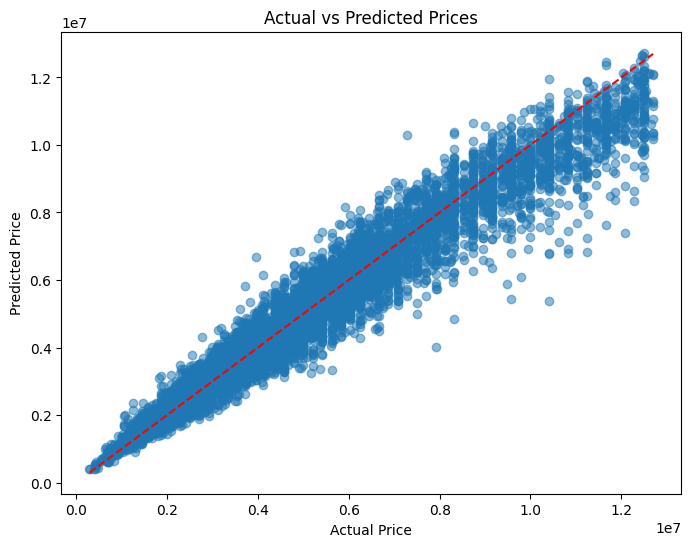

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(y_actual, y_pred, alpha=0.5)
plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='red', linestyle='--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.show()


From the picture we can see that model rather underestimater those apartment with higher prices. Maybe this is due to the fact that for such apartments there is less data

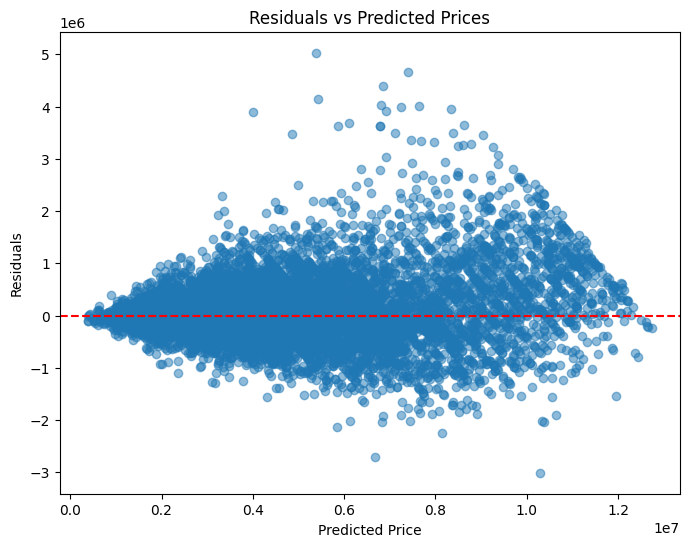

In [13]:
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Prices')
plt.show()


it looks like the biggest residuals are for the predicted prices around 6-8 mln (some outliers), otherwise the errors are distributed relatively evenly around 0 axis, so I cannot understand what is "blind zone" of the model

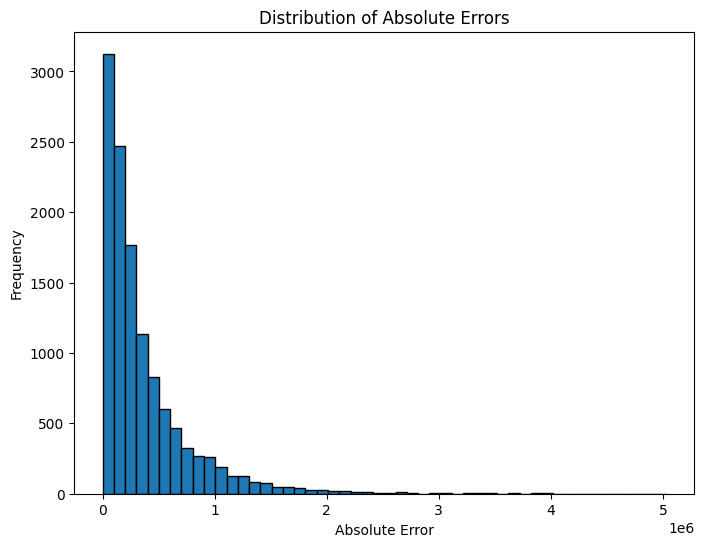

In [14]:
plt.figure(figsize=(8, 6))
plt.hist(abs_errors, bins=50, edgecolor='black')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.title('Distribution of Absolute Errors')
plt.show()


Most of abs.errors are next to zero, however, some really large errors happen (for a small amount of cases). It is interesting to look at the cases for which this is true.

<ipython-input-16-0bccdc082662>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_area = df.groupby(area_bins)['Absolute_Error'].mean()


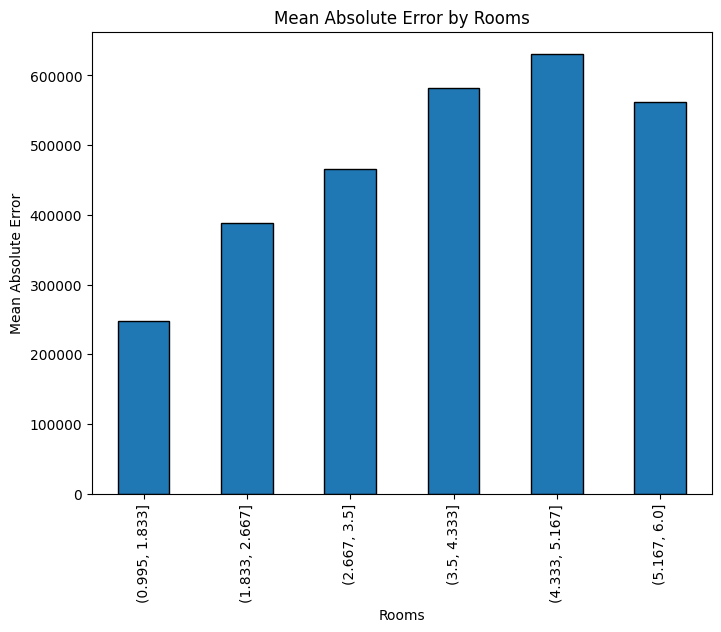

In [16]:
# Add absolute errors to the original dataframe
df['Absolute_Error'] = abs_errors

# Group by ranges of Area_total
area_bins = pd.cut(df['Rooms'], bins=6)
error_by_area = df.groupby(area_bins)['Absolute_Error'].mean()

# Plot error by area range
plt.figure(figsize=(8, 6))
error_by_area.plot(kind='bar', edgecolor='black')
plt.xlabel('Rooms')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error by Rooms')
plt.show()


In [17]:
# Calculate absolute errors
df['Absolute_Error'] = abs_errors

# Filter rows with absolute errors greater than 2 million
high_error_df = df[df['Absolute_Error'] > 2_000_000]


print(high_error_df.head(10))



                ID       Price  Price per sqm  Rooms  Area_total  \
288   1.781796e+09  12449239.0       123244.0    2.0       101.0   
298   1.794269e+09   9992700.0       171125.0    2.0        58.4   
332   1.898329e+09  12490875.0       100719.0    4.0       124.0   
430   1.701801e+09  11653987.0       155387.0    3.0        75.0   
501   1.146393e+09  11241788.0        63496.0    4.0       177.0   
592   1.922849e+09   6661800.0       125700.0    3.0        53.0   
899   1.979942e+09  11616514.0       149308.0    3.0        77.8   
907   1.608522e+09  12490875.0       138774.0    3.0        90.0   
929   1.946605e+09   9493065.0       193734.0    2.0        49.0   
1014  1.946633e+09  12074513.0       167711.0    2.0        72.0   

      Kitchen_area  Storeys  District ID   Latitude  Longitude  ...  \
288           25.0     23.0     10026676  50.446663  30.486674  ...   
298           25.0     23.0     10026676  50.446098  30.451805  ...   
332           20.0     19.0     100266

In [31]:
high_error_df.shape

(129, 43)

in general, there are not that many such huge errors

                   Rooms  Absolute_Error
Rooms           1.000000        0.229758
Absolute_Error  0.229758        1.000000


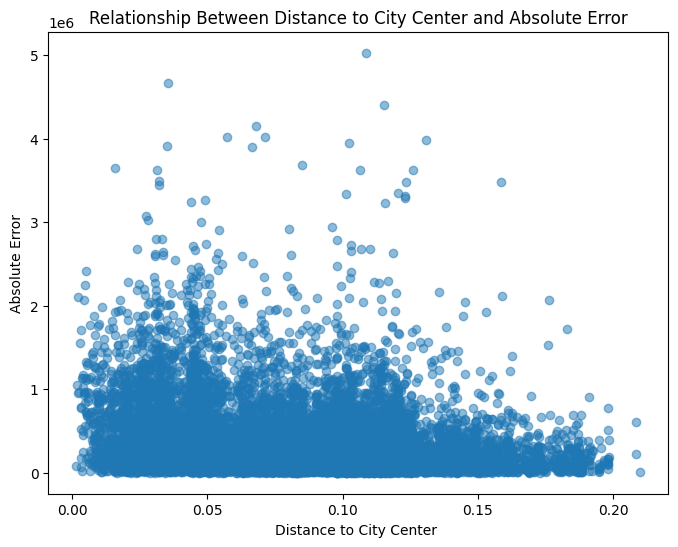

In [29]:
# Analyze relationship between 'distance_to_center' and 'Absolute_Error'
print(df[['Rooms', 'Absolute_Error']].corr())

# Optionally, plot the relationship
plt.figure(figsize=(8, 6))
plt.scatter(df['distance_to_center'], df['Absolute_Error'], alpha=0.5)
plt.xlabel('Distance to City Center ')
plt.ylabel('Absolute Error')
plt.title('Relationship Between Distance to City Center and Absolute Error')
plt.show()


Here it seems like the further the apartments are, the less the error. Lets see how many entries we have for different distance groups

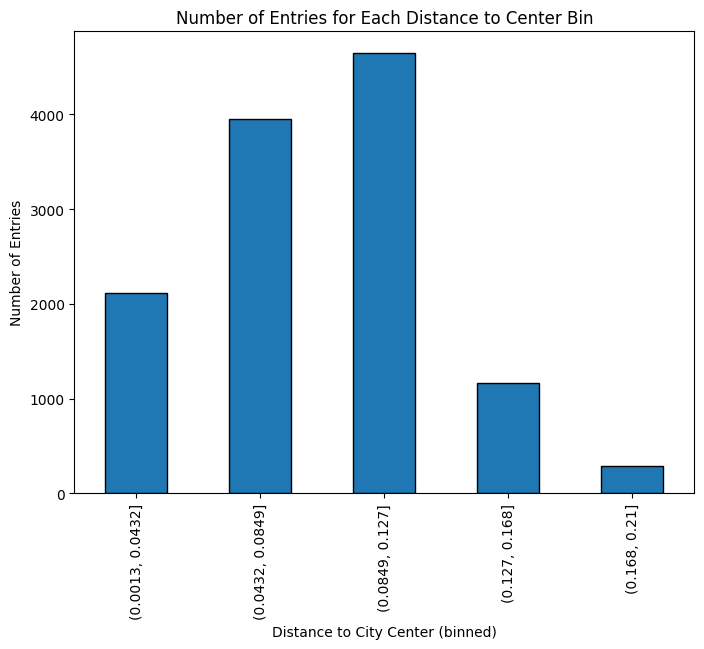

In [33]:
# Let's bin the distance_to_center column into 5 equal-width bins and display a histogram for how many entries fall into each bin.

# Create 5 bins for 'distance_to_center'
df['distance_bins'] = pd.cut(df['distance_to_center'], bins=5)

# Get the count of entries in each bin
bin_counts = df['distance_bins'].value_counts().sort_index()


# Plot histogram of entries per bin
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
bin_counts.plot(kind='bar', edgecolor='black')
plt.xlabel('Distance to City Center (binned)')
plt.ylabel('Number of Entries')
plt.title('Number of Entries for Each Distance to Center Bin')
plt.show()


So the problem is definitely not in the lack of data for the central apartments

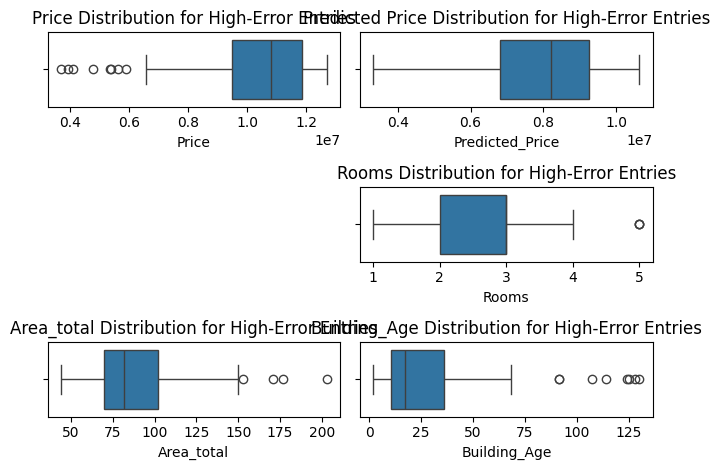

In [28]:
import seaborn as sns
df['Predicted_Price'] = y_pred
# Filter rows with absolute errors greater than 2 million
high_error_df = df[df['Absolute_Error'] > 2_000_000]

# Price
plt.subplot(3, 2, 1)
sns.boxplot(data=high_error_df, x='Price')
plt.title('Price Distribution for High-Error Entries')

# Predicted Price
plt.subplot(3, 2, 2)
sns.boxplot(data=high_error_df, x='Predicted_Price')
plt.title('Predicted Price Distribution for High-Error Entries')

# Rooms
plt.subplot(3, 2, 4)
sns.boxplot(data=high_error_df, x='Rooms')
plt.title('Rooms Distribution for High-Error Entries')

# Area_total
plt.subplot(3, 2, 5)
sns.boxplot(data=high_error_df, x='Area_total')
plt.title('Area_total Distribution for High-Error Entries')

# Building_Age
plt.subplot(3, 2, 6)
sns.boxplot(data=high_error_df, x='Building_Age')
plt.title('Building_Age Distribution for High-Error Entries')

# Adjust layout
plt.tight_layout()
plt.show()

